<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-ncen/form-ncen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Form N-CEN - Annual Reports by Investment Companies

This notebook demonstrates an exploratory data analysis examining annual reports by investment companies filed in SEC Form N-CEN.

Since 2018, when Form N-CEN superseded Form N-SAR, registered investment companies, especially funds, are required to file this form in XML format. Leveraging our [Form N-CEN - Annual Reports by Investment Companies API](https://sec-api.io/docs/form-ncen-api-annual-reports-investment-companies), we transform these disclosures into a standardized JSON format, facilitating comprehensive and efficient analysis.

Our analysis addresses several dimensions:

- Temporal trends in the number of Form Census Reports from 2018 to 2025, segmented by quarter, month, and intraday timing (pre-market, regular market hours, after-market).
- Statistics of number of directors
- Distribution of patterns across investment company characteristics and their temporal evolution
- Temporal evolution of the net assets owned by individual funds
- Temporal evolution of the line of credit size of funds


## Quick Start

To quickly retrieve data for a specific company, modify the following example as needed. For more detail, see [Form NCEN - Annual Reports by Investment Companies
API](https://sec-api.io/docs/form-ncen-api-annual-reports-investment-companies) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#form-ncen---annual-reports-investment-companies).


In [1]:
%pip install -q sec_api # use %pip for reliable install in current environment

Note: you may need to restart the kernel to use updated packages.


In [2]:
# NOTE: Replace with your own API key
API_KEY_SEC_API = "YOUR_API_KEY"

In [3]:
from sec_api import FormNcenApi
import json

formNcenApi = FormNcenApi(api_key=API_KEY_SEC_API)

search_params = {
    "query": "entities.cik:311635",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get proposed sales information, sales history, and other details
response = formNcenApi.get_data(search_params)
filing = response["data"]

print(json.dumps(filing, indent=2))

{
  "id": "201ccfd8ed1911b9b3ac93a74db53d23",
  "accessionNo": "0001752724-19-119817",
  "fileNo": "811-02924",
  "formType": "N-CEN",
  "filedAt": "2019-09-10T07:24:36-04:00",
  "entities": [
    {
      "cik": "311635",
      "companyName": "LORD ABBETT US GOV & GOV SPONSORED ENTERPR MONEY MARKET FUND (Filer)",
      "irsNo": "132986729",
      "fiscalYearEnd": "0630",
      "stateOfIncorporation": "MD",
      "act": "40",
      "fileNo": "811-02924",
      "filmNo": "191084275"
    }
  ],
  "seriesClass": {
    "reportSeriesClass": {
      "rptIncludeAllSeriesFlag": true
    }
  },
  "generalInfo": {
    "reportEndingPeriod": "2019-06-30",
    "isReportPeriodLt12": false
  },
  "registrantInfo": {
    "registrantFullName": "LORD ABBETT US GOV & GOV SPONSORED ENTERPR MONEY MARKET FUND",
    "investmentCompFileNo": "811-02924",
    "registrantCik": "311635",
    "registrantLei": "549300U1SLPHYW7Y1896",
    "registrantStreet1": "90 HUDSON STREET",
    "registrantCity": "JERSEY CITY",
 

## Download Dataset

To load and prepare the dataset of over 24,000 annual reports published as Form N-CEN filings since June 2018, we utilize the [Form NCEN - Annual Reports by Investment Companies
API](https://sec-api.io/docs/form-ncen-api-annual-reports-investment-companies).
The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time.

Once downloaded, all data objects are saved in JSONL format to `./form-ncen-dataset.jsonl.gz`.

Downloading the data may take several minutes.


In [4]:
import sys
import os
import time
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor

YEARS = range(2025, 2017, -1)  # from 2025 to 2018
TEMP_FILE_TEMPLATE = "./temp_file_form_ncen_{}.jsonl"
TARGET_FILE = "./form-ncen-dataset.jsonl.gz"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = formNcenApi.get_data(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} filings for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    import gzip

    # Merge the temporary files into one final compressed file
    with gzip.open(TARGET_FILE, "wt", encoding="utf-8") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r", encoding="utf-8") as infile:
                    for line in infile:
                        outfile.write(line)  # Preserve JSONL format
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Data


In [5]:
# install all dependencies required for the notebook
%pip install -q pandas numpy matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import skew, kurtosis

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

form_name = "Form N-CEN"
form_name_escaped = "form-ncen"

In [7]:
structured_data = pd.read_json(TARGET_FILE, lines=True)
structured_data = pd.json_normalize(structured_data.to_dict(orient="records"))

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)

structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)
structured_data["periodOfReportYear"] = structured_data["periodOfReport"].apply(
    lambda x: x.split("-")[0] if isinstance(x, str) else np.nan
)
structured_data["periodOfReportMonth"] = structured_data["periodOfReport"].apply(
    lambda x: x.split("-")[1] if isinstance(x, str) else np.nan
)

structured_data.head()

,id,accessionNo,fileNo,formType,filedAt,periodOfReport,entities,managementInvestmentQuestionSeriesInfo,exchangeSeriesInfo,closedEndManagementInvestment,...,closedEndManagementInvestment.isSmallTransferAgentHiredOrTerminated,closedEndManagementInvestment.longTermDebtDefaults,closedEndManagementInvestment.secondaryOfferings.otherSecondaryOfferingDesc,year,month,qtr,dayOfWeek,filedAtClass,periodOfReportYear,periodOfReportMonth
0,317027c631204f531e1b71f8cd916085,0001145549-18-005124,811-04014,N-CEN,2018-09-07 15:33:12-04:00,2018-06-30,"[{'cik': '745467', 'companyName': 'MERIDIAN FU...",[{'mgmtInvFundName': 'Meridian Small Cap Growt...,NaN,NaN,...,NaN,NaN,NaN,2018,9,3,Friday,regularMarket,2018,06
1,edfb246c09441654541851a673bfb34f,0001145549-18-005204,811-08039,N-CEN,2018-09-07 18:46:18-04:00,2018-06-28,"[{'cik': '1031661', 'companyName': 'THIRD AVEN...",[{'mgmtInvFundName': 'Third Avenue Focused Cre...,NaN,NaN,...,NaN,NaN,NaN,2018,9,3,Friday,afterMarket,2018,06
2,43bef4384f461953878f873df34daf94,0000035348-18-000026,811-03455,N-CEN,2018-09-10 14:52:26-04:00,2018-06-30,"[{'cik': '702149', 'companyName': 'NORTH CAROL...",[{'mgmtInvFundName': 'North Carolina Capital M...,NaN,NaN,...,NaN,NaN,NaN,2018,9,3,Monday,regularMarket,2018,06
3,adff9a862a68d281db5019e8a4a6e164,0001145549-18-005465,811-08200,N-CEN,2018-09-10 15:18:07-04:00,2018-06-30,"[{'cik': '916006', 'companyName': 'BRIDGEWAY F...",[{'mgmtInvFundName': 'Blue Chip 35 Index Fund'...,NaN,NaN,...,NaN,NaN,NaN,2018,9,3,Monday,regularMarket,2018,06
4,a671bfba4f54576204b2341caaa01901,0001145549-18-005486,811-09253,N-CEN,2018-09-10 15:44:05-04:00,2018-06-30,"[{'cik': '1081400', 'companyName': 'WELLS FARG...",[{'mgmtInvFundName': 'Alternative Strategies F...,NaN,NaN,...,NaN,NaN,NaN,2018,9,3,Monday,regularMarket,2018,06


In [8]:
# NCEN filings have only one entity related to the filing,
# meaning the investment company files the form themselves
# we can therefore extract the cik, company name and other information to the dataset
entity_count = (
    structured_data["entities"]
    .apply(lambda x: len(x) if isinstance(x, list) else 0)
    .value_counts()
    .keys()
)
if len(entity_count) > 1:
    print("Warning: Some filings have more than one entity related to the filing. ")
    print("Please check the data.")
else:
    print("All filings have only one entity related to the filing. ")
    print("Extracting the cik, company name and other information to the dataset.")
    flattened_entity = pd.json_normalize(
        structured_data["entities"].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {}
        ),
    )
    flattened_entity.columns = ["filer." + col for col in flattened_entity.columns]

    structured_data = pd.concat(
        [structured_data.drop(columns=["entities"]), flattened_entity],
        axis=1,
    )

All filings have only one entity related to the filing. 
Extracting the cik, company name and other information to the dataset.


In [9]:
unique_years = structured_data["year"].nunique()
unique_ciks = structured_data["filer.cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
max_year_full = max_year - 1  # to avoid incomplete data for the current year
print(f"Loaded dataframe with main documents of {form_name} filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
# print(f"Number of unique companies: {unique_companies:,}")
print(f"Number of unique ciks: {unique_ciks:,}")

Loaded dataframe with main documents of Form N-CEN filings
Number of filings: 24,744
Number of records: 24,744
Number of years: 8 (2018-2025)
Number of unique ciks: 3,327


In [10]:
structured_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24744 entries, 0 to 24743
Columns: 143 entries, id to filer.sic
dtypes: bool(15), datetime64[ns, US/Eastern](1), float64(19), int32(2), int64(1), object(105)
memory usage: 24.3+ MB


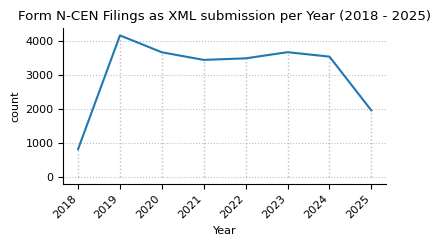

In [11]:
def plot_timeseries(
    ts,
    title,
    keys=["count"],
    y_label=None,
    ylog_scale=False,
    yvalue_multiplier=1,
    yvalue_multiplier_name=None,
    ax=None,
):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 2.5))
    else:
        fig = ax.figure

    # Auto y-label with unit
    if y_label is None:
        y_label = keys[0] if len(keys) == 1 else "Value"
    if yvalue_multiplier == "auto":
        yvalue_multiplier = 1
        max_value = ts[keys].max().max()
        if max_value > 1_000_000_000_000:
            yvalue_multiplier = 1_000_000_000_000
        elif max_value > 1_000_000_000:
            yvalue_multiplier = 1_000_000_000
        elif max_value > 1_000_000:
            yvalue_multiplier = 1_000_000
        elif max_value > 1_000:
            yvalue_multiplier = 1_000

    if yvalue_multiplier != 1:
        if yvalue_multiplier_name is not None:
            y_label = f"{y_label} ({yvalue_multiplier_name})"
        elif yvalue_multiplier == 1_000:
            y_label += " (Thousands)"
        elif yvalue_multiplier == 1_000_000:
            y_label += " (Millions)"
        elif yvalue_multiplier == 1_000_000_000:
            y_label += " (Billions)"
        elif yvalue_multiplier == 1_000_000_000_000:
            y_label += " (Trillions)"
        else:
            y_label += f" (÷{yvalue_multiplier:,})"

    # Apply multiplier
    ts_plot = ts.copy()
    ts_plot[keys] = ts_plot[keys] / yvalue_multiplier

    # Plot each key
    for key in keys:
        ts_plot[key].plot(ax=ax, label=key.capitalize())

    if ylog_scale:
        ax.set_yscale("log")

    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(y_label)
    ax.set_xticks(np.arange(min_year, max_year + 1, 1))
    # ax.set_xlim(min_year - 1, max_year + 1)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    # ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Add vertical lines at each year, height = max across all keys
    max_vals = ts_plot[keys].max(axis=1)
    for year in ts_plot.index:
        val = max_vals.get(year, 0)
        if not pd.isna(val):
            ax.vlines(year, 0, val, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.xticks(rotation=45, ha="right")
    if len(keys) > 1:
        ax.legend()

    plt.tight_layout()
    return fig, ax


filing_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

plot_timeseries(
    filing_counts,
    title=f"{form_name} Filings as XML submission per Year ({min_year} - {max_year})",
)
plt.show()

In [12]:
count_formType = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["formType"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Submission Type")
count_formType["Pct"] = (
    count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} Disclosures by Submission Type ({min_year} - {max_year})")
count_formType

Form N-CEN Disclosures by Submission Type (2018 - 2025)


,Count,Pct
Submission Type,,
N-CEN,"22,653",92%
N-CEN/A,"2,091",8%


In [13]:
form_counts_by_type_and_year = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "formType"])
    .size()
    .to_frame(name="count")
    .unstack(fill_value=0)
)

form_counts_by_type_and_year.loc["Total"] = form_counts_by_type_and_year.sum()
form_counts_by_type_and_year["Total"] = form_counts_by_type_and_year.sum(axis=1)


print(f"{form_name} counts from {min_year} to {max_year}.")
form_counts_by_type_and_year

Form N-CEN counts from 2018 to 2025.


count          Total
formType  N-CEN N-CEN/A       
year                          
2018        754      53    807
2019       3471     697   4168
2020       3363     306   3669
2021       3298     146   3444
2022       3330     160   3490
2023       3285     387   3672
2024       3278     263   3541
2025       1874      79   1953
Total     22653    2091  24744

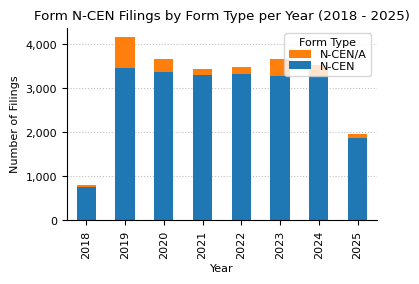

In [14]:
fig, ax = plt.subplots(figsize=(4, 2.5))
form_counts_by_type_and_year["count"].drop("Total").plot(
    kind="bar", stacked=True, ax=ax
)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)
ax.set_title(f"{form_name} Filings by Form Type per Year ({min_year} - {max_year})")
plt.show()

In [15]:
counts_qtr_yr_piv = (
    structured_data.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

print(f"{form_name} counts by quarter from {min_year} to {max_year}.")
counts_qtr_yr_piv.T

Form N-CEN counts by quarter from 2018 to 2025.


year,2018,2019,2020,2021,2022,2023,2024,2025
qtr,,,,,,,,
1,0,2239,2083,1984,1988,1997,2060,1953
2,0,644,492,440,458,492,459,0
3,158,604,494,435,447,438,420,0
4,649,681,600,585,597,745,602,0


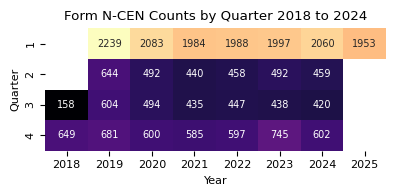

In [16]:
plt.figure(figsize=(4, 2))
sns.heatmap(
    counts_qtr_yr_piv.T,
    annot=True,  # Display the cell values
    fmt="d",  # Integer formatting
    cmap="magma",  # Color map
    cbar_kws={"label": "Count"},  # Colorbar label
    mask=counts_qtr_yr_piv.T == 0,  # Mask the cells with value 0
    cbar=False,
    annot_kws={"fontsize": 7},
)
plt.grid(False)
plt.title(f"{form_name} Counts by Quarter {min_year} to {max_year_full}")
plt.xlabel("Year")
plt.ylabel("Quarter")
plt.tight_layout()
plt.show()

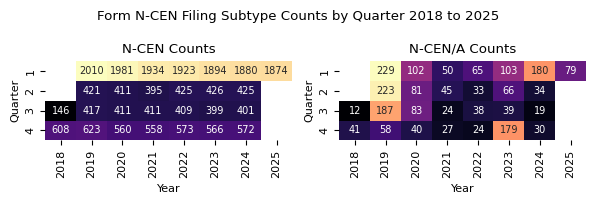

In [17]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(6, 2))

cnt = 0
for formType in form_types:
    data = (
        structured_data[structured_data["formType"] == formType]
        .groupby(["year", "qtr"])
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
        .reindex(columns=range(1, 5), fill_value=0)  # ensure all month are included
    )

    filing_name = formType
    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]

    sns.heatmap(
        data.T,
        ax=ax,
        annot=True,  # Display the cell values
        fmt="d",  # Integer formatting
        cmap="magma",  # Color map
        cbar_kws={"label": "Count"},  # Colorbar label
        mask=data.T == 0,  # Mask the cells with value 0
        cbar=False,
        annot_kws={"fontsize": 7},
    )
    ax.grid(False)
    ax.set_title(f"{filing_name} Counts")
    ax.set_xlabel("Year")
    ax.set_ylabel("Quarter")

    cnt += 1

fig.suptitle(f"{form_name} Filing Subtype Counts by Quarter {min_year} to {max_year}")
plt.tight_layout()

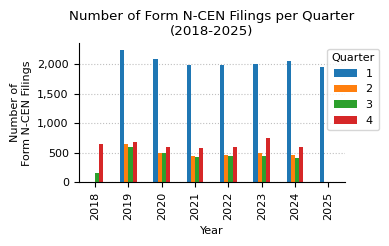

In [18]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(4, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.15, 1))
ax.set_title(f"Number of {form_name} Filings per Quarter\n({min_year}-{max_year})")
ax.set_xlabel("Year")
ax.set_ylabel(f"Number of\n{form_name} Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

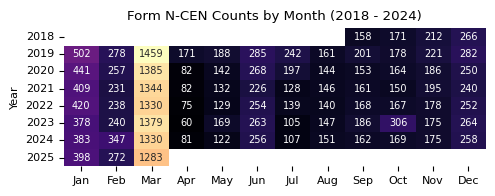

In [19]:
counts_month_yr_piv = (
    structured_data.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

plt.figure(figsize=(5, 2))
sns.heatmap(
    counts_month_yr_piv,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar_kws={"label": "Count"},
    mask=counts_month_yr_piv == 0,
    cbar=False,
    annot_kws={"size": 7},
)
# convert x-labels to month names: 1 => Jan, 2 => Feb, etc.
plt.xticks(
    ticks=np.arange(0.5, 12.5, 1),
    labels=[pd.to_datetime(str(i), format="%m").strftime("%b") for i in range(1, 13)],
)
plt.grid(False)
plt.title(f"{form_name} Counts by Month ({min_year} - {max_year_full})")
plt.xlabel("")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

In [20]:
print(
    f"Descriptive statistics for {form_name} filing counts by month from {min_year} to {max_year}."
)
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Form N-CEN filing counts by month from 2018 to 2025.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,8,8,8,8,8,8,8,8,8,8,8,8
mean,366,233,1189,69,110,194,115,111,149,163,168,226
std,153,101,483,54,71,121,85,69,62,82,70,92
min,0,0,0,0,0,0,0,0,0,0,0,0
2.5%,66,40,225,0,0,0,0,0,27,26,31,42
50%,404,248,1337,78,130,255,118,145,162,168,182,255
97.5%,491,335,1446,155,185,282,234,159,198,284,219,279
max,502,347,1459,171,188,285,242,161,201,306,221,282


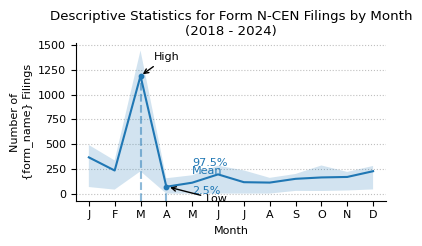

In [21]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,
    pos_high_low=None,
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title=f"Descriptive Statistics for {form_name} Filings by Month\n({min_year} - {max_year_full})",
    x_label="Month",
    y_label="Number of\n{form_name} Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

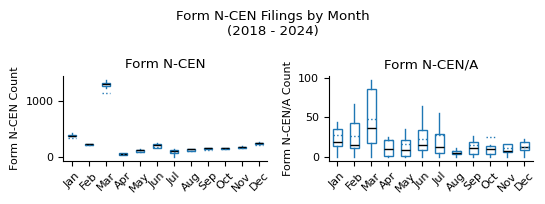

In [22]:
form_types = count_formType.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(5.5, 2))

cnt = 0
for formType in form_types:

    data = (
        structured_data[structured_data["formType"] == formType]
        .groupby(["year", "month"])
        .size()
        .unstack()
        .fillna(0)
        .reindex(columns=range(1, 13), fill_value=0)  # ensure all month are included
    )

    # if data.sum().sum() < 100:
    #     continue

    ax = axes.flatten()[cnt]
    cnt += 1
    try:
        data.boxplot(
            ax=ax,
            grid=False,
            showfliers=False,
            flierprops=dict(marker="o", markersize=3),
            patch_artist=True,
            boxprops=dict(facecolor="white", color="tab:blue"),
            showmeans=True,
            meanline=True,
            meanprops={"color": "tab:blue", "linestyle": ":"},
            medianprops={"color": "black"},
            capprops={"color": "none"},
        )

        ax.set_title(f"Form {formType}")
        ax.set_xlabel("")
        ax.set_ylabel(f"Form {formType} Count")
        xticklabels = [
            pd.to_datetime(str(x), format="%m").strftime("%b") for x in range(1, 13)
        ]
        ax.set_xticklabels(xticklabels)
        ax.tick_params(axis="x", rotation=45)
    except Exception as e:
        print(f"Error: {e}")

# disable the empty subplots
for i in range(cnt, len(axes.flatten())):
    axes.flatten()[i].axis("off")

fig.suptitle(f"{form_name} Filings by Month\n({min_year} - {max_year_full})")
plt.tight_layout()
plt.show()

In [23]:
counts_per_month_by_formType = (
    structured_data[["year", "month", "accessionNo", "formType"]]
    .groupby(["year", "month", "formType"])
    .count()
    .rename(columns={"accessionNo": "count"})
    .pivot_table(
        index=["year", "month"],  # Rows
        columns="formType",  # Columns
        values="count",  # Values to fill
        fill_value=0,  # Replace NaN with 0
    )
    .astype(int)
    .reset_index()  # Make year and month normal columns
)

counts_per_month_by_formType

formType,year,month,N-CEN,N-CEN/A
0,2018,9,146,12
1,2018,10,161,10
2,2018,11,196,16
3,2018,12,251,15
4,2019,1,421,81
...,...,...,...,...
74,2024,11,167,8
75,2024,12,249,9
76,2025,1,376,22
77,2025,2,234,38


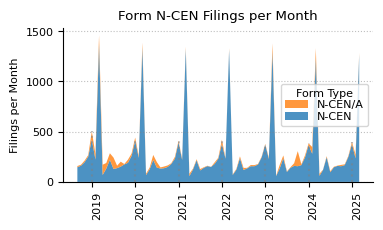

In [24]:
fix, ax = plt.subplots(figsize=(4, 2))

ax.stackplot(
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str),
    *[counts_per_month_by_formType[ft] for ft in form_types],
    labels=[f"{ft}" for ft in form_types],
    alpha=0.8,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    list(reversed(handles)),
    list(reversed(labels)),
    title="Form Type",
    labelspacing=0.15,
)

ax.set_title(f"{form_name} Filings per Month")
ax.set_ylabel("Filings per Month")
xticks = (
    counts_per_month_by_formType["year"].astype(str)
    + "-"
    + counts_per_month_by_formType["month"].astype(str)
)
ax.set_xticks([i for i, x in enumerate(xticks) if x.endswith("-1")])
ax.set_xticklabels(
    [label.get_text()[:4] for label in ax.get_xticklabels()], rotation=90, ha="left"
)

ax.grid(axis="y", linestyle=":", alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# draw vertical lines for each first month of the year, dotted, transparency 0.5,
# with height of the y value for the respective month
for year, month in counts_per_month_by_formType[["year", "month"]].values:
    if month == 1:
        ax.vlines(
            f"{year}-{month}",
            ymin=0,
            ymax=counts_per_month_by_formType[
                (counts_per_month_by_formType["year"] == year)
                & (counts_per_month_by_formType["month"] == month)
            ]
            .drop(columns=["year", "month"])
            .sum(axis=1),
            linestyle=":",
            alpha=0.5,
            color="grey",
        )

plt.show()

In [25]:
counts_filedAtClass = (
    (
        structured_data.drop_duplicates(subset=["accessionNo"])
        .groupby(["filedAtClass"])
        .size()
        .sort_values(ascending=False)
        .to_frame(name="Count")
    )
    .rename_axis("Publication Time")
    .sort_values("Count", ascending=True)
)
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"{form_name} filing counts by pre-market, regular market hours,\n"
    f"and after-market publication time ({min_year} - {max_year_full})."
)
counts_filedAtClass

Form N-CEN filing counts by pre-market, regular market hours,
and after-market publication time (2018 - 2024).


,Count,Pct
Publication Time,,
regularMarket,"17,393",70%
After Market (4:00 - 8:00 PM),"4,887",20%
Pre-Market (4:00 - 9:30 AM),"2,319",9%
other,145,1%


In [26]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"{form_name} filing counts by day of the week ({min_year} - {max_year}).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Form N-CEN filing counts by day of the week (2018 - 2025).


,Count,Pct
Day of the Week,,
Monday,"4,545",18%
Tuesday,"4,619",19%
Wednesday,"4,573",18%
Thursday,"4,568",18%
Friday,"6,439",26%


## Director Statistics


In [27]:
# first reduce the following to registrantInfo.isAnyDirectorInterestedPerson
# "registrantInfo.directors.isDirectorInterestedPerson":
#   "Indicator showing if the director is considered an interested person.",
structured_data["noDirectors"] = structured_data["registrantInfo.directors"].apply(
    lambda x: (
        len(list(set([d["directorName"] for d in x])))
        if isinstance(x, list)
        else np.nan
    )
)  # number of directors
print(structured_data["noDirectors"].value_counts())

noDirectors
9.0     2550
10.0    2533
11.0    2418
4.0     2171
5.0     1943
6.0     1639
8.0     1558
7.0     1395
12.0    1162
3.0      941
13.0     525
14.0     292
15.0     163
16.0     102
17.0      67
2.0       56
1.0       33
19.0      33
18.0       1
Name: count, dtype: int64


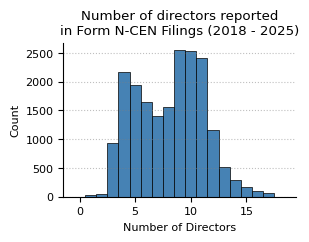

,noDirectors
Samples,19582
Mean,8.12
Median,9.00
Std.,3.10
25%,5.00
75%,10.00
Min,1.00
Max,19.00
Skewness,0.13
Kurtosis,2.45


In [28]:
def plot_hist(
    data,
    title=None,
    x_label=None,
    y_label=None,
    log_scale=False,
    xlog_scale=False,
    ylog_scale=False,
    bins=None,
    xticks=None,
    use_xticks_formatter=False,
    use_yticks_formatter=False,
    value_multiplier=1,
    value_range=None,
    ax=None,
    integer_bins=False,
):
    if log_scale:
        xlog_scale = True
        ylog_scale = True

    data = np.array(data)

    # Filter
    if value_range is not None:
        min_val, max_val = value_range
        data = data[(data >= min_val) & (data <= max_val)]

    # Auto xvalue_multiplier
    if value_multiplier == "auto":
        value_multiplier = 1
        max_value = np.max(data)
        if max_value > 1_000_000_000_000:
            value_multiplier = 1_000_000_000_000
        elif max_value > 1_000_000_000:
            value_multiplier = 1_000_000_000
        elif max_value > 1_000_000:
            value_multiplier = 1_000_000
        elif max_value > 1_000:
            value_multiplier = 1_000

    # Apply multiplier
    data = data / value_multiplier

    # Label unit
    if value_multiplier != 1:
        if x_label is None:
            x_label = "Value"
        if value_multiplier == 1_000:
            unit = " (Thousands)"
        elif value_multiplier == 1_000_000:
            unit = " (Millions)"
        elif value_multiplier == 1_000_000_000:
            unit = " (Billions)"
        elif value_multiplier == 1_000_000_000_000:
            unit = " (Trillion)"
        else:
            unit = f" (÷{value_multiplier:,})"
        x_label += unit

    # Create figure/ax if not given
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 2))

    # Bins
    if bins is not None and isinstance(bins, int):
        data_range = data.max() - data.min()
        if data_range < bins and integer_bins:
            bins = np.arange(data.min() - 0.5, data.max() + 1.5, 1)
    if bins is None:
        if integer_bins:
            min_val = np.floor(data.min())
            max_val = np.ceil(data.max())
            bin_edges = np.arange(min_val - 0.5, max_val + 1.5, 1)
        elif xlog_scale:
            bin_edges = np.logspace(np.log10(data.min()), np.log10(data.max()), num=20)
        else:
            bin_edges = 20
    else:
        bin_edges = bins

    if value_multiplier != 1 and isinstance(bin_edges, np.ndarray):
        bin_edges = bin_edges / value_multiplier

    ax.hist(
        data,
        bins=bin_edges,
        color="steelblue",
        edgecolor="black",
        linewidth=0.5,
    )

    if xticks is not None:
        ax.set_xticks(xticks)
    if xlog_scale:
        ax.set_xscale("log")
        use_xticks_formatter = True
    if ylog_scale:
        ax.set_yscale("log")
        use_yticks_formatter = True
    if use_xticks_formatter:
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.tick_params(axis="x", rotation=45)
    if use_yticks_formatter:
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    return fig, ax


def basic_stats_table(
    data, columns: list[str] = None, number_formatter: str = "{x:.2f}"
) -> pd.DataFrame:
    # Handle Series input by converting to single-column DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()
        columns = [data.columns[0]]
    elif isinstance(data, pd.DataFrame):
        if columns is None:
            raise ValueError(
                "For DataFrame input, please provide a list of column names."
            )
    else:
        raise TypeError("Input must be a pandas DataFrame or Series.")

    summary_data = {}

    for col in columns:
        series = data[col].dropna()
        summary_data[col] = {
            "Samples": len(series),
            "Mean": number_formatter.format(x=series.mean()),
            "Median": number_formatter.format(x=series.median()),
            "Std.": number_formatter.format(x=series.std()),
            "25%": number_formatter.format(x=series.quantile(0.25)),
            "75%": number_formatter.format(x=series.quantile(0.75)),
            "Min": number_formatter.format(x=series.min()),
            "Max": number_formatter.format(x=series.max()),
            "Skewness": round(skew(series), 2),
            "Kurtosis": round(kurtosis(series, fisher=False), 2),
        }

    return pd.DataFrame(summary_data).T


plot_hist(
    structured_data["noDirectors"],
    title=f"Number of directors reported\nin {form_name} Filings ({min_year} - {max_year})",
    x_label="Number of Directors",
    y_label="Count",
    bins=np.arange(0, np.max(structured_data["noDirectors"]) + 1) - 0.5,
)
plt.show()


basic_stats_table(
    structured_data,
    columns=["noDirectors"],
).T

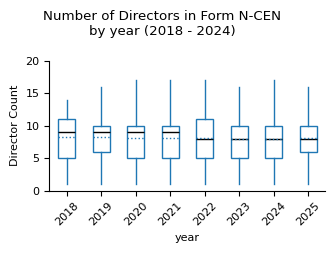

In [29]:
fig, ax = plt.subplots(1, figsize=(3.5, 2.5))

filtered_data = structured_data.drop_duplicates(
    subset=["filer.cik", "year"]
)  # to avoid double counting

cnt = 0

years = range(min_year, max_year + 1)

data = filtered_data.pivot(columns="year", values="noDirectors")


data.boxplot(
    ax=ax,
    grid=False,
    showfliers=False,
    flierprops=dict(marker="o", markersize=3),
    patch_artist=True,
    boxprops=dict(facecolor="white", color="tab:blue"),
    showmeans=True,
    meanline=True,
    meanprops={"color": "tab:blue", "linestyle": ":"},
    medianprops={"color": "black"},
    capprops={"color": "none"},
)

ax.set_xlabel("year")
ax.set_ylabel(f"Director Count")
ax.tick_params(axis="x", rotation=45)
ax.set_ylim(0, 20)

fig.suptitle(
    f"Number of Directors in {form_name}\nby year ({min_year} - {max_year_full})"
)
plt.tight_layout()
plt.show()

In [30]:
structured_data["noDirectorsInterestedPerson"] = structured_data[
    "registrantInfo.directors"
].apply(
    lambda x: (
        len([d for d in x if d["isDirectorInterestedPerson"]])
        if isinstance(x, list)
        else 0
    )
)
structured_data["percentageDirectorsInterestedPerson"] = (
    structured_data["noDirectorsInterestedPerson"] / structured_data["noDirectors"]
).fillna(0)
structured_data["isAnyDirectorInterestedPerson"] = structured_data[
    "registrantInfo.directors"
].apply(
    lambda x: any(
        [d["isDirectorInterestedPerson"] for d in x] if isinstance(x, list) else [False]
    )
)
print()

print(structured_data["noDirectorsInterestedPerson"].value_counts())
print(structured_data["noDirectorsInterestedPerson"].value_counts())
print(structured_data["isAnyDirectorInterestedPerson"].value_counts())


noDirectorsInterestedPerson
1    9078
0    8271
2    6785
3     548
4      47
6       7
5       6
7       2
Name: count, dtype: int64
noDirectorsInterestedPerson
1    9078
0    8271
2    6785
3     548
4      47
6       7
5       6
7       2
Name: count, dtype: int64
isAnyDirectorInterestedPerson
True     16473
False     8271
Name: count, dtype: int64


## Distribution of Filings by Investment Company Characteristics


In [31]:
bool_variables_to_analyze = [
    "registrantInfo.isRegistrantFirstFiling",
    "registrantInfo.isRegistrantLastFiling",
    "registrantInfo.isRegistrantFamilyInvComp",
    "registrantInfo.isSecuritiesActRegistration",
    "isAnyDirectorInterestedPerson",
    "registrantInfo.isRegistrantSubmittedMatter",
    "registrantInfo.isPreviousLegalProceeding",
    "registrantInfo.isClaimFiled",
    "registrantInfo.isFinancialSupportDuringPeriod",
    "registrantInfo.isExemptionFromAct",
    "registrantInfo.isUnderwriterHiredOrTerminated",
    "registrantInfo.isPublicAccountantChanged",
    "registrantInfo.isMaterialWeakness",
    "registrantInfo.isOpinionOffered",
    "registrantInfo.isMaterialChange",
    "registrantInfo.isAccountingPrincipleChange",
    "registrantInfo.isPaymentErrorInNetAssetValue",
    "registrantInfo.isPaymentDividend",
]

var_to_label = {
    "registrantInfo.isRegistrantFirstFiling": "Registrant First Filing",
    "registrantInfo.isRegistrantLastFiling": "Registrant Final Filing",
    "registrantInfo.isRegistrantFamilyInvComp": "Part of Investment Company Family",
    "registrantInfo.isSecuritiesActRegistration": "Registered under Securities Act",
    "isAnyDirectorInterestedPerson": "Director With Potential Interest Conflict",
    "registrantInfo.isRegistrantSubmittedMatter": "Submitted Matter",
    "registrantInfo.isPreviousLegalProceeding": "Previous Legal Proceeding",
    "registrantInfo.isClaimFiled": "Claim Filed",
    "registrantInfo.isFinancialSupportDuringPeriod": "Financial Support Provided",
    "registrantInfo.isExemptionFromAct": "Exempt from Act",
    "registrantInfo.isUnderwriterHiredOrTerminated": "Underwriter Hired or Terminated",
    "registrantInfo.isPublicAccountantChanged": "Public Accountant Changed",
    "registrantInfo.isMaterialWeakness": "Material Weakness Identified",
    "registrantInfo.isOpinionOffered": "Audit Opinion Offered",
    "registrantInfo.isMaterialChange": "Material Change",
    "registrantInfo.isAccountingPrincipleChange": "Accounting Principle Change",
    "registrantInfo.isPaymentErrorInNetAssetValue": "Payment Error in NAV",
    "registrantInfo.isPaymentDividend": "Dividend Payment",
}

bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        structured_data[variable]
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={variable: "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)


bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(
    index=var_to_label, columns={"count": "Samples", "pct": "Pct."}, inplace=True
)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(
    lambda x: f"{x:,.0f}"
)

print(
    f"Number of {form_name} filings by \ndisclosed registrant characteristics (2004 - 2024):"
)
bool_variables_stats

Number of Form N-CEN filings by 
disclosed registrant characteristics (2004 - 2024):


Samples   Pct.
Variable                                  Value               
Registrant First Filing                   True    3,887   15.7
                                          False  20,857   84.3
Registrant Final Filing                   True      662    2.7
                                          False  24,082   97.3
Part of Investment Company Family         True   19,111   77.2
                                          False   5,633   22.8
Registered under Securities Act           True   22,873   92.4
                                          False   1,871    7.6
Director With Potential Interest Conflict True   16,473   66.6
                                          False   8,271   33.4
Submitted Matter                          True    5,751   23.2
                                          False  18,993   76.8
Previous Legal Proceeding                 True      418    1.7
                                          False  24,326   98.3
Claim Filed                               True       67    0.3
                                          False  19,660   99.7
Financial Support Provided                True      134    0.5
                                          False  24,610   99.5
Exempt from Act                           True   13,369   54.0
                                          False  11,375   46.0
Underwriter Hired or Terminated           True      697    2.8
                                          False  24,047   97.2
Public Accountant Changed                 True    1,015    4.1
                                          False  23,729   95.9
Material Weakness Identified              True      140    0.7
                                          False  19,454   99.3
Audit Opinion Offered                     True       17    0.1
                                          False  24,727   99.9
Material Change                           True      523    2.1
                                          False  24,221   97.9
Accounting Principle Change               True        6    0.0
                                          False  24,738  100.0
Payment Error in NAV                      True      812    4.6
                                          False  16,949   95.4
Dividend Payment                          True    6,046   30.4
                                          False  13,836   69.6

evolution by year of report period

- number of directors with potential conflict of interest
- isFinancialSupportDuringPeriod


Evolution of disclosed registrant characteristics
counting one filing per registrant and year
in Form N-CEN filings (2004 - 2024):


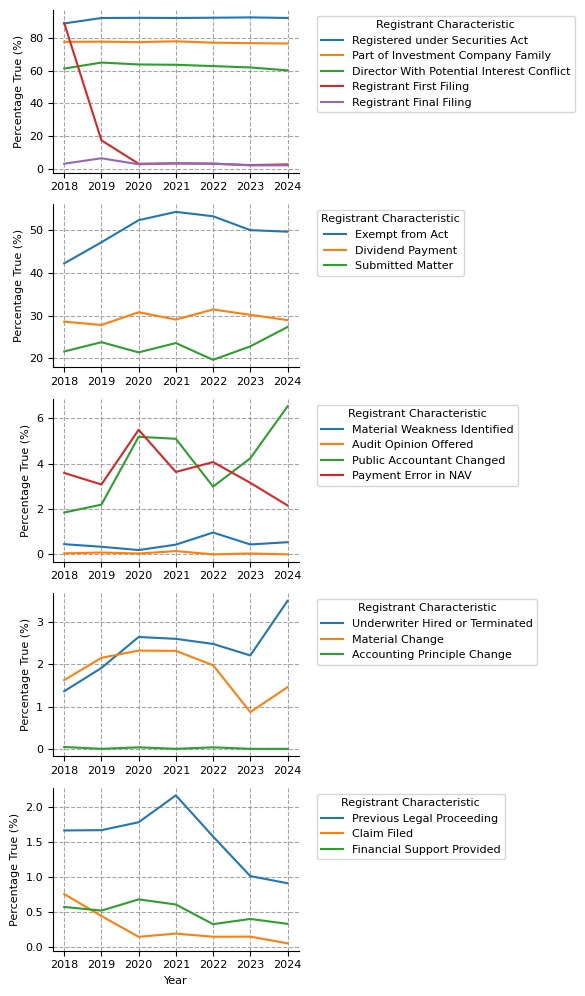

In [32]:
# Filter data for valid years
structured_data["periodOfReportYear"] = pd.to_numeric(
    structured_data["periodOfReportYear"], errors="coerce"
)
filtered_data = structured_data.dropna(subset=["periodOfReportYear"]).drop_duplicates(
    subset=["filer.cik", "periodOfReportYear"]
)

# Calculate percentages for each flag by year
# Note: We only consider years before the max_year to avoid incomplete data
flag_percentages = {}
for flag in bool_variables_to_analyze:
    flag_percentages[flag] = (
        filtered_data[filtered_data["periodOfReportYear"] < max_year]
        .groupby("periodOfReportYear")[flag]
        .mean()
        .mul(100)  # Convert to percentage
    )

# Plot the evolution of percentages in groups of 5 flags using subplots
flags_per_subplot = 5
flags_subsets = [
    bool_variables_to_analyze[i : i + flags_per_subplot]
    for i in range(0, len(bool_variables_to_analyze), flags_per_subplot)
]

# manual selection for better visualization
flags_subsets = [
    [
        "registrantInfo.isSecuritiesActRegistration",
        "registrantInfo.isRegistrantFamilyInvComp",
        "isAnyDirectorInterestedPerson",
        "registrantInfo.isRegistrantFirstFiling",
        "registrantInfo.isRegistrantLastFiling",
    ],
    [
        "registrantInfo.isExemptionFromAct",
        "registrantInfo.isPaymentDividend",
        "registrantInfo.isRegistrantSubmittedMatter",
    ],
    [
        "registrantInfo.isMaterialWeakness",
        "registrantInfo.isOpinionOffered",
        "registrantInfo.isPublicAccountantChanged",
        "registrantInfo.isPaymentErrorInNetAssetValue",
    ],
    [
        "registrantInfo.isUnderwriterHiredOrTerminated",
        "registrantInfo.isMaterialChange",
        "registrantInfo.isAccountingPrincipleChange",
    ],
    [
        "registrantInfo.isPreviousLegalProceeding",
        "registrantInfo.isClaimFiled",
        "registrantInfo.isFinancialSupportDuringPeriod",
    ],
]


num_subplots = len(flags_subsets)
fig, axes = plt.subplots(num_subplots, 1, figsize=(6, 2 * num_subplots))


for i, ax in enumerate(axes):
    start_idx = i * flags_per_subplot
    end_idx = start_idx + flags_per_subplot
    flags_subset = flags_subsets[i]

    for flag in flags_subset:
        percentages = flag_percentages[flag]
        ax.plot(percentages.index, percentages.values, label=var_to_label[flag])

    ax.set_ylabel("Percentage True (%)")
    ax.legend(
        title="Registrant Characteristic", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.grid(axis="x", linestyle="--", alpha=0.7)

axes[-1].set_xlabel("Year")
plt.tight_layout()

print(
    f"Evolution of disclosed registrant characteristics\n"
    f"counting one filing per registrant and year\nin {form_name} filings (2004 - 2024):"
)
bool_variables_stats
plt.show()

## Management and Investment Questions

Form N-CEN includes the "Management and Investment Question Series Info" field which refers to a set of questions that gather detailed information about each series (or fund) within a registrant that is management investment company (as opposed to unit investment trusts or face-amount certificate companies).

In this section, we extract and analyze the net asset value and the line of credit size on a fund by fund basis.


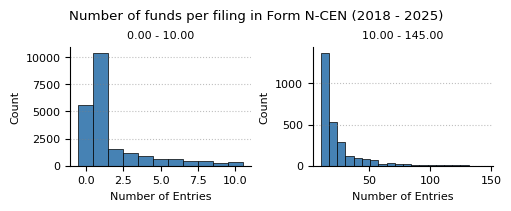

,managementInvestmentQuestionSeriesInfo
Samples,24744
Mean,4.01
Median,1.00
Std.,9.38
25%,1.00
75%,3.00
Min,0.00
Max,145.00
Skewness,6.05
Kurtosis,54.27


In [33]:
def format_with_order_of_magnitude(value, precision=2):
    """
    Format a large number with appropriate order of magnitude and given precision.
    Examples:
        1_523_000_234 with prec=2 -> "1.52 Billion"
        15_300_000 with prec=1 -> "15.3 Million"
    """
    abs_val = abs(value)
    if abs_val >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.{precision}f} Trillion"
    elif abs_val >= 1_000_000_000:
        return f"{value / 1_000_000_000:.{precision}f} Billion"
    elif abs_val >= 1_000_000:
        return f"{value / 1_000_000:.{precision}f} Million"
    elif abs_val >= 1_000:
        return f"{value / 1_000:.{precision}f} Thousand"
    else:
        return f"{value:.{precision}f}"


def plot_split_histograms(
    data,
    value_splits,
    x_label="Value",
    y_label="Count",
    title="Histogram",
    figsize=(2.5, 2),
    force_xticks_at_bounds=True,
    **kwargs,
):
    import matplotlib.pyplot as plt
    import numpy as np

    value_splits = sorted(value_splits)
    min_val = min(data)
    max_val = max(data)
    ranges = (
        [(min_val, value_splits[0])]
        + [(value_splits[i], value_splits[i + 1]) for i in range(len(value_splits) - 1)]
        + [(value_splits[-1], max_val)]
    )

    fig, axes = plt.subplots(
        1,
        len(ranges),
        figsize=(figsize[0] * len(ranges), figsize[1]),
        constrained_layout=True,
    )

    fig.suptitle(title)

    if len(ranges) == 1:
        axes = [axes]

    for i, (low, high) in enumerate(ranges):
        xticks = None
        if force_xticks_at_bounds:
            n_ticks = 5
            xticks = np.linspace(low, high, n_ticks)
            xticks = np.unique(np.append(xticks, [low, high]))
            if kwargs.get("integer_bins", False):
                xticks = np.unique(np.round(xticks).astype(int))

        _, ax = plot_hist(
            data,
            x_label=x_label,
            y_label=y_label,
            value_range=(low, high),
            # xticks=xticks,
            use_xticks_formatter=kwargs.get("use_xticks_formatter", False),
            ax=axes[i],
            **kwargs,
        )

        low_string = format_with_order_of_magnitude(low)
        high_string = format_with_order_of_magnitude(high)
        ax.set_title(
            f"{low_string} - {high_string}",
            fontsize=8,
        )

    plt.show()


num_fund_info = structured_data["managementInvestmentQuestionSeriesInfo"].apply(
    lambda x: (len(x) if isinstance(x, list) else 0)
)

plot_split_histograms(
    num_fund_info,
    value_splits=[10],
    x_label="Number of Entries",
    y_label="Count",
    title=f"Number of funds per filing in {form_name} ({min_year} - {max_year})",
    integer_bins=True,
    bins=20,
)

basic_stats_table(num_fund_info).T

In [34]:
exploded = structured_data.explode("managementInvestmentQuestionSeriesInfo").dropna(
    subset=["managementInvestmentQuestionSeriesInfo"]
)

# Filter to rows where the value is a dict
exploded = exploded[
    exploded["managementInvestmentQuestionSeriesInfo"].apply(
        lambda x: isinstance(x, dict)
    )
]

# Normalize the nested dict column
fund_info = pd.json_normalize(
    exploded["managementInvestmentQuestionSeriesInfo"]
).assign(
    accessionNo=exploded["accessionNo"].values,
    cik=exploded["filer.cik"].values,
    periodOfReport=exploded["periodOfReport"].values,
    year=exploded["year"].values,
)

In [35]:
counts_fund_types = (
    fund_info.explode("fundTypes").groupby("fundTypes").size().to_frame(name="Count")
).rename_axis("Fund Type")

counts_fund_types.sort_values("Count", ascending=False, inplace=True)
counts_fund_types["Pct"] = (
    counts_fund_types["Count"].astype(int)
    / counts_fund_types["Count"].astype(int).sum()
).map("{:.1%}".format)
counts_fund_types["Count"] = counts_fund_types["Count"].map(lambda x: f"{x:,}")

print(
    f"Fund types of funds included in the\nManagement and Investment Questions Section\nof {form_name} ({min_year} - {max_year})."
)
counts_fund_types.head(10)

Fund types of funds included in the
Management and Investment Questions Section
of Form N-CEN (2018 - 2025).


,Count,Pct
Fund Type,,
N/A,"47,381",37.0%
Exchange-Traded Fund,"20,140",15.7%
Index Fund,"19,074",14.9%
Underlying fund,"15,162",11.8%
Fund of Funds,"13,075",10.2%
Target Date Fund,"5,068",4.0%
Money Market Fund,"2,758",2.2%
Master-Feeder Fund,"2,496",1.9%
Inverse of a benchmark,"2,286",1.8%


### Net Assets


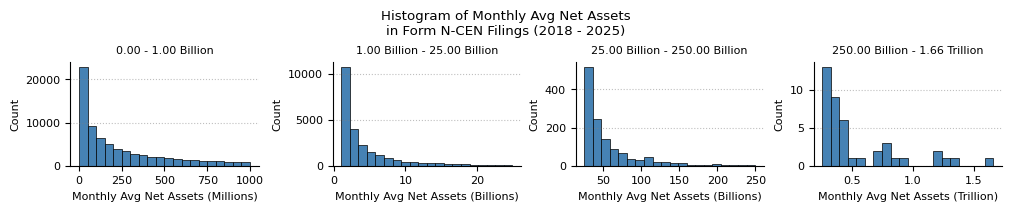

,monthlyAvgNetAssets
Samples,96763
Mean,"2,177,371,233"
Median,"263,393,321"
Std.,"15,507,723,309"
25%,"55,634,868"
75%,"1,050,919,560"
Min,0
Max,"1,657,803,028,651"
Skewness,48.91
Kurtosis,3639.26


In [36]:
net_assets = pd.to_numeric(fund_info["monthlyAvgNetAssets"], errors="coerce").dropna()

plot_split_histograms(
    net_assets,
    value_splits=[
        1_000_000_000,
        25_000_000_000,
        250_000_000_000,
    ],
    x_label="Monthly Avg Net Assets",
    y_label="Count",
    title=f"Histogram of Monthly Avg Net Assets\nin {form_name} Filings ({min_year} - {max_year})",
    bins=20,
    value_multiplier="auto",
    force_xticks_at_bounds=False,
)


basic_stats_table(net_assets, number_formatter="{x:,.0f}").T

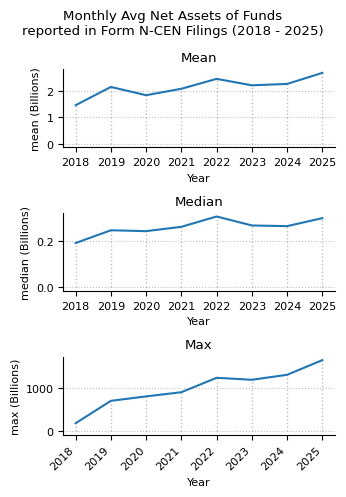

In [37]:
# Convert to numeric
fund_info["monthlyAvgNetAssets"] = pd.to_numeric(
    fund_info["monthlyAvgNetAssets"], errors="coerce"
)

# Group by year and calculate stats
net_asset_stats = fund_info.groupby("year")["monthlyAvgNetAssets"].agg(
    min="min", max="max", mean="mean", median="median"
)

fig, axes = plt.subplots(nrows=3, figsize=(3.5, 5))
fig.suptitle(
    f"Monthly Avg Net Assets of Funds\nreported in {form_name} Filings ({min_year} - {max_year})"
)
axes = axes.flatten()
for ax, key in zip(axes, ["mean", "median", "max"]):
    pretty_key = key.capitalize()
    plot_timeseries(
        ts=net_asset_stats,
        title=f"{pretty_key}",
        keys=[key],
        ylog_scale=False,
        yvalue_multiplier=1_000_000_000,
        ax=ax,
    )

In [38]:
print(
    f"Largest 20 funds by Monthly Avg Net Assets Of Funds"
    f"\nreported in {form_name} Filings ({min_year}-{max_year})"
)
largest_funds = (
    fund_info[
        ["cik", "monthlyAvgNetAssets", "mgmtInvFundName", "mgmtInvSeriesId", "year"]
    ]
    .dropna()
    .sort_values(by="monthlyAvgNetAssets", ascending=False)
    .drop_duplicates("mgmtInvSeriesId")
    .reset_index(drop=True)
)
cik_to_name = {
    row["filer.cik"]: row["filer.companyName"] for _, row in structured_data.iterrows()
}
largest_funds["companyName"] = largest_funds["cik"].map(cik_to_name)
largest_funds["monthlyAvgNetAssets"] = largest_funds["monthlyAvgNetAssets"].map(
    lambda x: f"{x:,.0f}"
)
largest_funds.head(20)

Largest 20 funds by Monthly Avg Net Assets Of Funds
reported in Form N-CEN Filings (2018-2025)


,cik,monthlyAvgNetAssets,mgmtInvFundName,mgmtInvSeriesId,year,companyName
0,36405,"1,657,803,028,651",VANGUARD TOTAL STOCK MARKET INDEX FUND,S000002848,2025,VANGUARD INDEX FUNDS (Filer)
1,36405,"1,191,939,011,244",VANGUARD 500 INDEX FUND,S000002839,2025,VANGUARD INDEX FUNDS (Filer)
2,819118,"425,776,739,665",Fidelity 500 Index Fund,S000006027,2024,FIDELITY CONCORD STREET TRUST (Filer)
3,736054,"424,981,754,455",VANGUARD TOTAL INTERNATIONAL STOCK INDEX FUND,S000002932,2025,VANGUARD STAR FUNDS (Filer)
4,1100663,"365,829,120,904",iShares Core S&P 500 ETF,S000004310,2024,iSHARES TRUST (Filer)
5,794105,"327,240,669,304",VANGUARD TOTAL BOND MARKET INDEX FUND,S000002564,2025,VANGUARD BOND INDEX FUNDS (Filer)
6,862084,"297,339,754,480",VANGUARD INSTITUTIONAL INDEX FUND,S000002853,2025,VANGUARD INSTITUTIONAL INDEX FUNDS (Filer)
7,794105,"292,851,383,854",VANGUARD TOTAL BOND MARKET II INDEX FUND,S000025158,2025,VANGUARD BOND INDEX FUNDS (Filer)
8,44201,"257,361,111,179",GROWTH FUND OF AMERICA,S000009228,2021,GROWTH FUND OF AMERICA (Filer)
9,36405,"246,213,215,256",VANGUARD GROWTH INDEX FUND,S000002842,2025,VANGUARD INDEX FUNDS (Filer)


In [39]:
print(
    f"Largest 20 Investment Companies by Monthly Avg Net Assets"
    f" Of Funds\nreported in {form_name} Filings for 2024"
)
# group by cik and year and sum the monthlyAvgNetAssets
funds_by_company = (
    fund_info[["cik", "monthlyAvgNetAssets", "year"]]
    .dropna()
    .groupby(["cik", "year"])
    .sum()
    .sort_values("monthlyAvgNetAssets", ascending=False)
    .reset_index()
)
funds_by_company["companyName"] = funds_by_company["cik"].map(cik_to_name)
funds_by_company_2024 = funds_by_company[funds_by_company["year"] == 2024]
largest_funds_by_company = funds_by_company_2024.nlargest(20, "monthlyAvgNetAssets")
largest_funds_by_company["monthlyAvgNetAssets"] = largest_funds_by_company[
    "monthlyAvgNetAssets"
].map(lambda x: f"{x:,.0f}")
largest_funds_by_company[largest_funds_by_company["year"] == 2024]

Largest 20 Investment Companies by Monthly Avg Net Assets Of Funds
reported in Form N-CEN Filings for 2024


,cik,year,monthlyAvgNetAssets,companyName
2,36405,2024,"3,016,562,644,025",VANGUARD INDEX FUNDS (Filer)
7,1100663,2024,"2,238,616,603,051",iSHARES TRUST (Filer)
14,355437,2024,"1,122,100,958,209",DFA INVESTMENT DIMENSIONS GROUP INC (Filer)
19,810893,2024,"845,336,359,636",PIMCO FUNDS (Filer)
22,819118,2024,"750,899,617,729",FIDELITY CONCORD STREET TRUST (Filer)
23,752177,2024,"718,906,077,825",VANGUARD CHESTER FUNDS (Filer)
25,1567101,2024,"694,989,454,970",Bridge Builder Trust (Filer)
27,794105,2024,"685,300,840,224",VANGUARD BOND INDEX FUNDS (Filer)
40,35315,2024,"483,037,692,208",FIDELITY SALEM STREET TRUST (Filer)
47,736054,2024,"442,375,836,688",VANGUARD STAR FUNDS (Filer)


### Line of Credit


In [40]:
exploded = fund_info.dropna(subset=["lineOfCredit"]).explode(["lineOfCredit"])
exploded = exploded[exploded["year"] <= 2024]
# Normalize the nested dict column
credit_line_info = pd.json_normalize(exploded["lineOfCredit"])
credit_line_info = credit_line_info.assign(
    accessionNo=exploded["accessionNo"].values,
    cik=exploded["cik"].values,
    periodOfReport=exploded["periodOfReport"].values,
    year=exploded["year"].values,
    mgmtInvSeriesId=exploded["mgmtInvSeriesId"].values,
)

In [41]:
per_fund_per_year = (
    credit_line_info.groupby(["mgmtInvSeriesId", "year"])["lineOfCreditSize"]
    .mean()
    .reset_index()
)

loc_stats_per_fund = per_fund_per_year.groupby("year")["lineOfCreditSize"].agg(
    min="min", max="max", mean="mean", median="median"
)
loc_stats_per_fund

,min,max,mean,median
year,,,,
2018,155000.0,3.100000e+09,6.828066e+08,2.765000e+08
2019,0.0,9.000000e+09,6.059292e+08,3.250000e+08
2020,0.0,4.300000e+09,6.700100e+08,4.000000e+08
2021,0.0,4.300000e+09,7.064601e+08,4.821429e+08
2022,0.0,4.385000e+09,7.257335e+08,4.821429e+08
2023,0.0,4.385000e+09,7.474646e+08,4.821429e+08
2024,0.0,4.300000e+09,7.316043e+08,4.821429e+08


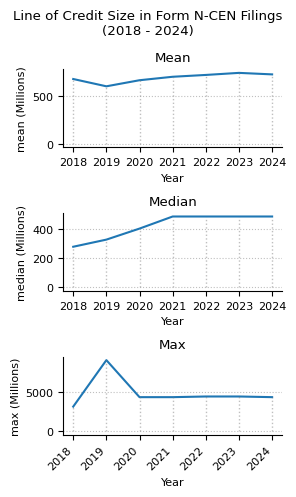

In [42]:
fig, axes = plt.subplots(nrows=3, figsize=(3, 5))

fig.suptitle(
    f"Line of Credit Size in {form_name} Filings\n({min_year} - {max_year_full})"
)

axes = axes.flatten()
for ax, key in zip(axes, ["mean", "median", "max"]):
    pretty_key = key.capitalize()
    plot_timeseries(
        ts=loc_stats_per_fund,
        title=f"{pretty_key}",
        keys=[key],
        ylog_scale=False,
        yvalue_multiplier=1_000_000,
        ax=ax,
    )